In [4]:
import mitsuba as mi
import drjit as dr
import matplotlib.pyplot as plt
import numpy as np
import gc

In [5]:
mi.set_variant('cuda_ad_rgb')

In [24]:
scene_description = {
    'type': 'scene',
    'heightfield': {
        'type': 'heightfield',
        'filename': 'data/interpolated2.bmp',
        'max_height': 1.0,
        #'to_world': mi.ScalarTransform4f.scale(0.25),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.5, 0.5, 0.5]
            }
        }
    },
    'sensor' :{
        'type': 'perspective',
        'to_world': mi.ScalarTransform4f.look_at(
            #origin=[0, 0, 1], target=[0, 0, 0], up=[0, 1, 0]
            origin=[0, -5, 1], target=[0, 0, 0], up=[0, 0, 1]
            #origin=[0, 0, 1], target=[0, 0, 0], up=[0, 1, 0]
        ),
#         'near_clip': 10,
#         'far_clip':2800,
        'film': {
            'type': 'hdrfilm',
            'width': 500,
            'height': 500,
            'sample_border': True
        },
        'sampler': {
            'type': 'independent',
            'sample_count': 2048,
        }
    },
    'integrator': {
        'type': 'direct_reparam',
        'reparam_rays': 128,
        'reparam_antithetic': True,
        'reparam_kappa': 10**6,
    },
    
        
       'sphere_2': {
        'type': 'sphere',
        'center': [0, -7, 1],
        'radius': 1,
       'emitter': {
            'type': 'area',
            'radiance': {
                'type': 'rgb',
                'value': 1.0,
            }
        }
    }    
  
#     'emitter': {
#         'type': 'constant',
#     }
}

In [20]:
scene_description_direct = {
    'type': 'scene',
    'heightfield': {
        'type': 'heightfield',
        'filename': 'data/interpolated2.bmp',
        'max_height': 1.0,
        #'to_world': mi.ScalarTransform4f.scale(0.25),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.5, 0.5, 0.5]
            }
        }
    },
    'sensor' :{
        'type': 'perspective',
        'to_world': mi.ScalarTransform4f.look_at(
            #origin=[0, 0, 1], target=[0, 0, 0], up=[0, 1, 0]
            origin=[0, -5, 1], target=[0, 0, 0], up=[0, 0, 1]
            #origin=[0, 0, 1], target=[0, 0, 0], up=[0, 1, 0]
        ),
#         'near_clip': 10,
#         'far_clip':2800,
        'film': {
            'type': 'hdrfilm',
            'width': 500,
            'height': 500,
            'sample_border': True
        },
        'sampler': {
            'type': 'independent',
            'sample_count': 1024,
        }
    },
#     'integrator' :{
#         'type':'path',
#     },
    'integrator': {
        'type': 'direct',
    },
    'emitter': {
        'type': 'constant',
    }
}

In [65]:
def compute_primal_and_fd():
    res = [500, 500]
    fd_spp = 128
    fd_repeat = 100
    fd_integrator = mi.load_dict({"type": "direct"})

    img1 = dr.zeros(mi.TensorXf, (res[0], res[1], 3))
    img2 = dr.zeros(mi.TensorXf, (res[0], res[1], 3))
    for it in range(fd_repeat):
        scene, _, _ = load_scene(scene_description, -epsilon)
        img1 += fd_integrator.render(scene, spp=fd_spp, seed=it)
        scene, _, _ = load_scene(scene_description, +epsilon)
        img2 += fd_integrator.render(scene, spp=fd_spp, seed=it)
        print(f"{it+1}/{fd_repeat}", end='\r')
        
    img_fd = (img2 - img1) / (epsilon*2) / fd_repeat
    img_primal = img1 # / fd_repeat

    return img_primal, img_fd

In [8]:
epsilon = 4e-3 #5e-4
key = 'heightfield.to_world'

## Translation

In [9]:
axis = 'x'

In [10]:
def load_scene(scene_json, x=0.0, axis='x'):
    scene = mi.load_dict(scene_json)

    params = mi.traverse(scene)
    params.keep([key])

    theta = mi.Float(x)
    dr.enable_grad(theta)

    if axis == 'x':
        translation = mi.Transform4f.translate([theta, 0, 0])
    elif axis == 'y':
        translation = mi.Transform4f.translate([0, theta, 0])
    else:
        translation = mi.Transform4f.translate([0, 0, theta])
    
    params[key] = translation @ mi.Transform4f.scale(1.0)
    params.update()

    dr.forward(theta, dr.ADFlag.ClearEdges)

    dr.set_label(params=params)
    dr.set_label(theta=theta)

    return scene, params, theta

In [ ]:
img_primal, img_fd = compute_primal_and_fd()
mi.Bitmap(img_fd).write(f"output/heightfield/fd_translation_{axis}_continuous_delta{epsilon}.exr")
mi.Bitmap(img_primal).write(f"output/heightfield/primal_translation_{axis}_continuous.exr")

In [31]:
scene, params, theta = load_scene(scene_description, axis=axis)

img_prb_reparam = scene.integrator().render_forward(scene, params=params)
img_prb_bmp_reparam = mi.Bitmap(img_prb_reparam)
img_prb_bmp_reparam.write(f"output/heightfield/prb_reparam_translation_{axis}_continuous.exr")

del scene, params, theta
gc.collect(); gc.collect();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


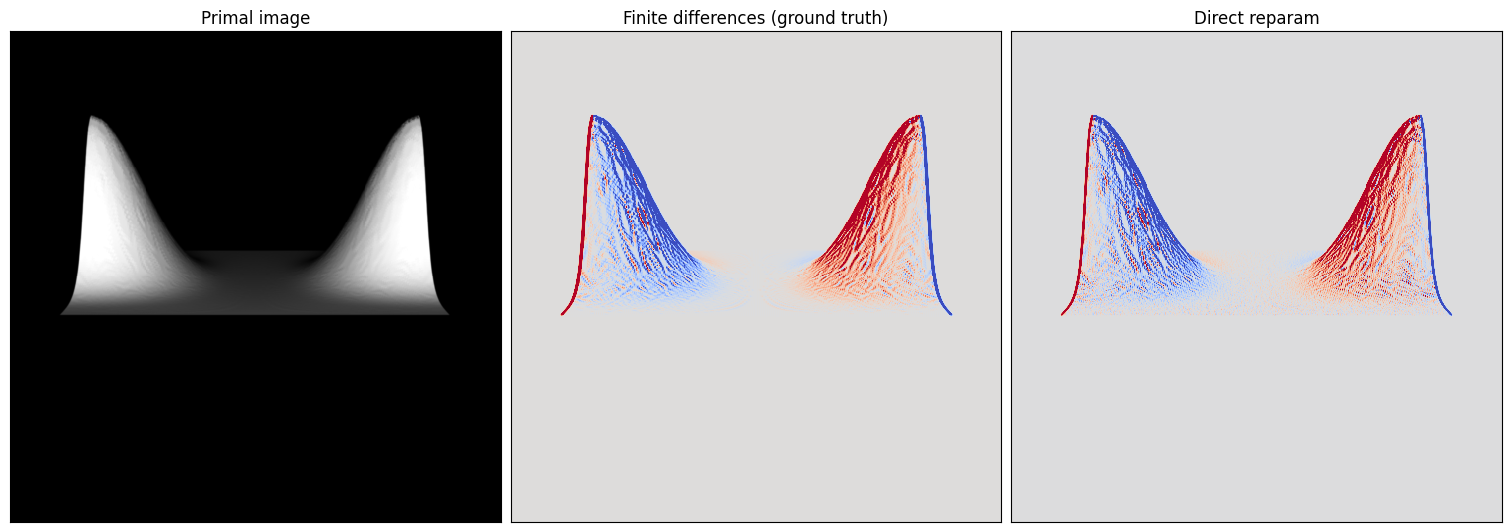

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10), constrained_layout=True)

grad_amplitude = 2.0

ax = axes[0]
ax.imshow(img_primal, extent=[0,1,0,1], interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Primal image')

r = np.quantile(np.abs(img_fd), 0.99)

def plot_grad_img(ax, img, title):
    img = np.array(img).mean(axis=2) * grad_amplitude
    ax.imshow(img, vmin=-r, vmax=r, cmap='coolwarm_r', extent=[0,1,0,1], interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

plot_grad_img(axes[1], img_fd, 'Finite differences (ground truth)')
plot_grad_img(axes[2], img_prb_bmp_reparam, 'Direct reparam')

## Rotation

In [45]:
axis = 'x'
epsilon = 0.1

In [46]:
def load_scene(scene_json, x=0.0, axis='x'):
    scene = mi.load_dict(scene_json)

    params = mi.traverse(scene)
    params.keep([key])

    theta = mi.Float(x)
    dr.enable_grad(theta)

    if axis == 'x':
        rotation = mi.Transform4f.rotate([1, 0, 0], theta)
    elif axis == 'y':
        rotation = mi.Transform4f.rotate([0, 1, 0], theta)
    else:
        rotation = mi.Transform4f.rotate([0, 0, 1], theta)
    params[key] = rotation @ mi.Transform4f.scale(1.0)
    params.update()

    dr.forward(theta, dr.ADFlag.ClearEdges)

    dr.set_label(params=params)
    dr.set_label(theta=theta)

    return scene, params, theta

In [ ]:
img_primal, img_fd = compute_primal_and_fd()
mi.Bitmap(img_fd).write(f"output/heightfield/fd_rotation_{axis}.exr")
mi.Bitmap(img_primal).write(f"output/heightfield/primal_rotation_{axis}.exr")

In [49]:
scene, params, theta = load_scene(scene_description, axis=axis)

img_prb_reparam = scene.integrator().render_forward(scene, params=params)
img_prb_bmp_reparam = mi.Bitmap(img_prb_reparam)
img_prb_bmp_reparam.write(f"output/heightfield/prb_reparam_rotation_{axis}.exr")

del scene, params, theta
gc.collect(); gc.collect();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


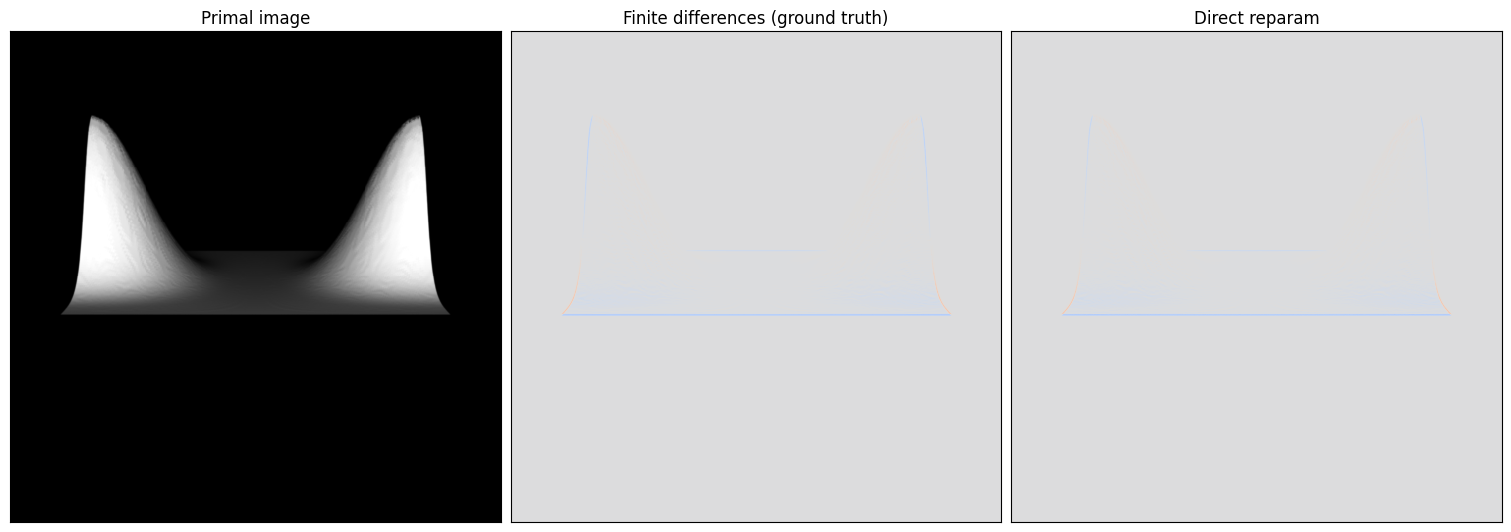

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10), constrained_layout=True)

grad_amplitude = 0.05

ax = axes[0]
ax.imshow(img_primal, extent=[0,1,0,1], interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Primal image')

r = np.quantile(np.abs(img_fd), 0.99)

def plot_grad_img(ax, img, title):
    img = np.array(img).mean(axis=2) * grad_amplitude
    ax.imshow(img, vmin=-r, vmax=r, cmap='coolwarm_r', extent=[0,1,0,1], interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

plot_grad_img(axes[1], img_fd, 'Finite differences (ground truth)')
plot_grad_img(axes[2], img_prb_bmp_reparam, 'Direct reparam')

## Scale

In [55]:
epsilon = 0.0001

In [56]:
def load_scene(scene_json, x=0.0):
    scene = mi.load_dict(scene_description)

    params = mi.traverse(scene)
    params.keep([key])

    theta = mi.Float(x)
    dr.enable_grad(theta)

    params[key] = mi.Transform4f.scale(1 + theta)
    params.update()

    dr.forward(theta, dr.ADFlag.ClearEdges)

    dr.set_label(params=params)
    dr.set_label(theta=theta)

    return scene, params, theta

In [57]:
scene, params, theta = load_scene(scene_description_direct, -epsilon)
img_primal = mi.render(scene)
primal_bmp = mi.Bitmap(img_primal)
primal_bmp.write(f"output/heightfield/primal_scaling.exr")
del scene, params, theta
gc.collect(); gc.collect();

scene, params, theta = load_scene(scene_description_direct, epsilon)
img_fd = mi.render(scene)
img_fd_bmp = mi.Bitmap((img_fd - img_primal) / (2 * epsilon))
img_fd_bmp.write(f"output/heightfield/fd_scaling.exr")
del scene, params, theta
gc.collect(); gc.collect();

In [ ]:
img_primal, img_fd = compute_primal_and_fd()
mi.Bitmap(img_fd).write(f"output/heightfield/fd_scaling.exr")
mi.Bitmap(img_primal).write(f"output/heightfield/primal_scaling.exr")

In [60]:
scene, params, theta = load_scene(scene_description)

img_prb_reparam = scene.integrator().render_forward(scene, params=params)
img_prb_bmp_reparam = mi.Bitmap(img_prb_reparam)
img_prb_bmp_reparam.write(f"output/heightfield/prb_reparam_scaling.exr")

del scene, params, theta
gc.collect(); gc.collect();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


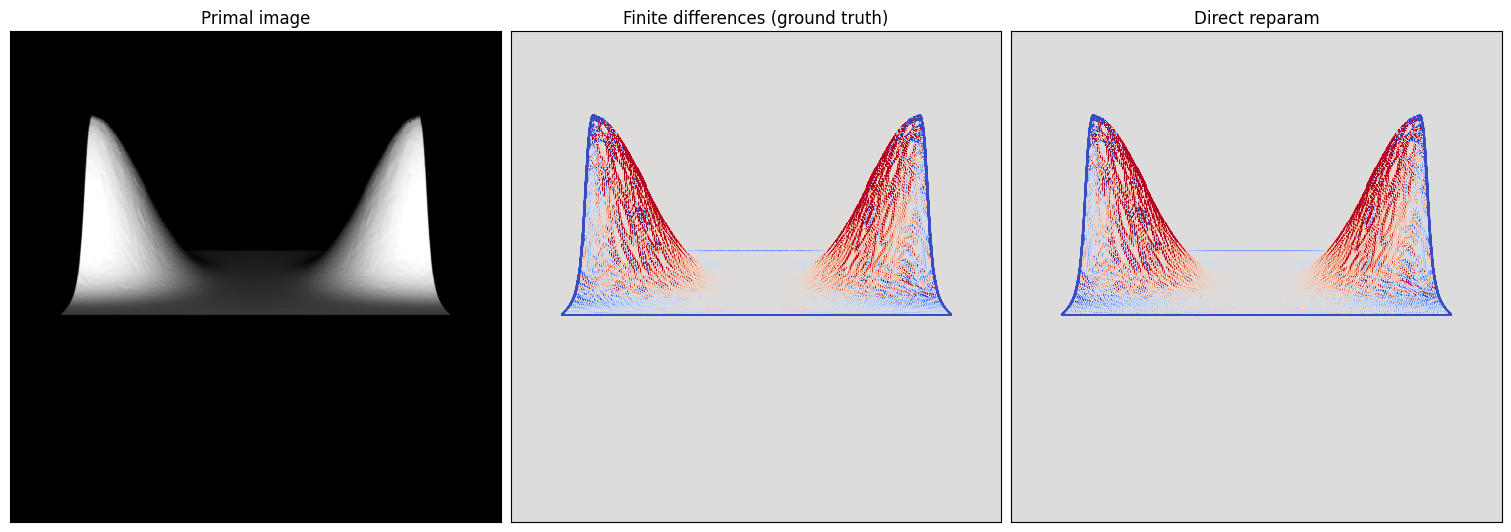

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10), constrained_layout=True)

grad_amplitude = 2.0

ax = axes[0]
ax.imshow(img_primal, extent=[0,1,0,1], interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Primal image')

r = np.quantile(np.abs(img_fd), 0.99)

def plot_grad_img(ax, img, title):
    img = np.array(img).mean(axis=2) * grad_amplitude
    ax.imshow(img, vmin=-r, vmax=r, cmap='coolwarm_r', extent=[0,1,0,1], interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

plot_grad_img(axes[1], img_fd, 'Finite differences (ground truth)')
plot_grad_img(axes[2], img_prb_bmp_reparam, 'Direct reparam')

## Max height

In [62]:
key = 'heightfield.max_height'
epsilon=0.01

In [68]:
def load_scene(scene_json, x=0.0):
    scene = mi.load_dict(scene_json)

    params = mi.traverse(scene)
    params.keep([key])

    theta = mi.Float(x)
    dr.enable_grad(theta)

    params[key] += theta
    params.update()

    dr.forward(theta, dr.ADFlag.ClearEdges)

    dr.set_label(params=params)
    dr.set_label(theta=theta)

    return scene, params, theta

In [69]:
img_primal, img_fd = compute_primal_and_fd()
mi.Bitmap(img_fd).write(f"output/heightfield/fd_translation_{axis}_continuous_delta{epsilon}.exr")
mi.Bitmap(img_primal).write(f"output/heightfield/primal_translation_{axis}_continuous.exr")

In [71]:
scene, params, theta = load_scene(scene_description)
img_prb_reparam = scene.integrator().render_forward(scene, params=params)
img_prb_bmp_reparam = mi.Bitmap(img_prb_reparam)
img_prb_bmp_reparam.write(f"output/heightfield/prb_reparam_max_height.exr")

del scene, params, theta
gc.collect(); gc.collect();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


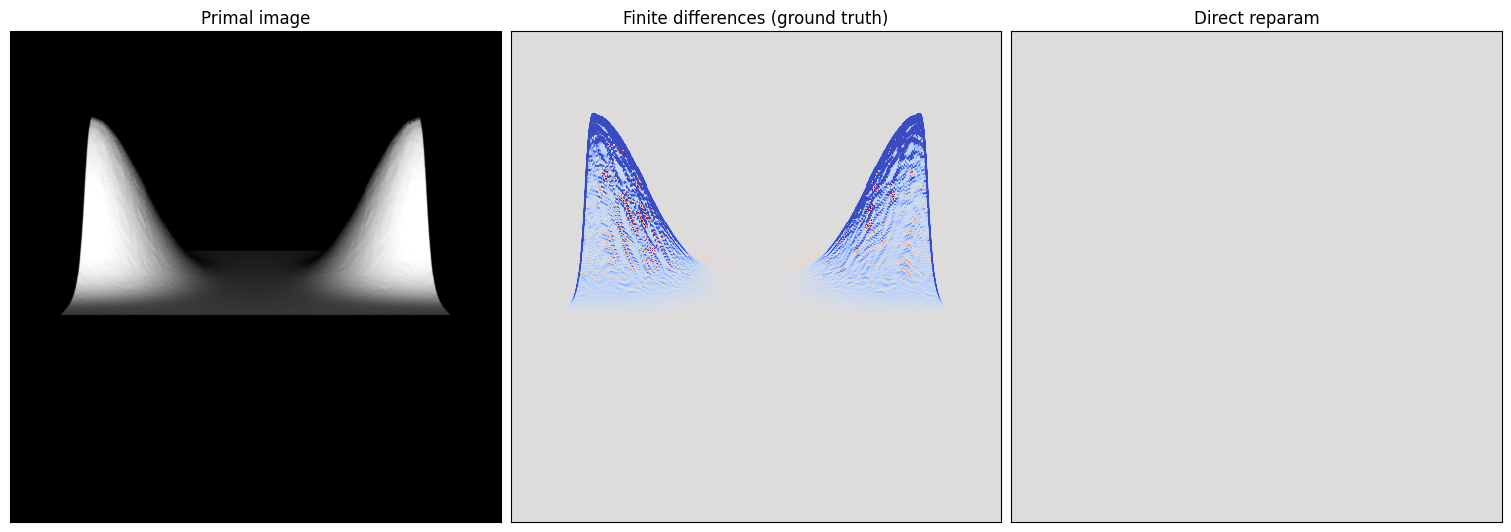

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10), constrained_layout=True)

grad_amplitude = 2.0

ax = axes[0]
ax.imshow(img_primal, extent=[0,1,0,1], interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Primal image')

r = np.quantile(np.abs(img_fd), 0.99)

def plot_grad_img(ax, img, title):
    img = np.array(img).mean(axis=2) * grad_amplitude
    ax.imshow(img, vmin=-r, vmax=r, cmap='coolwarm_r', extent=[0,1,0,1], interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

plot_grad_img(axes[1], img_fd, 'Finite differences (ground truth)')
plot_grad_img(axes[2], img_prb_bmp_reparam, 'Direct reparam')